# Online GP update demo

The goal of this notebook is to look into how to properly update an (exact inference) Gaussian process (GP) regression model where the initial training data is None and the GP is continuously conditioned on incoming training data in an online fashion.

In [8]:
import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.mlls import ExactMarginalLogLikelihood

# Define a custom ExactGP model
class GPRegressionModel(ExactGP):
    def __init__(self, likelihood):
        super(GPRegressionModel, self).__init__(None, None, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [9]:
# Initialize likelihood
likelihood = GaussianLikelihood()

# Initialize model
model = GPRegressionModel(likelihood)

In [10]:
# Set model and likelihood to training mode
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [11]:
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

In [12]:

# Define a function for the training loop
def train_model(train_x_, train_y_, model_, mll, likelihood, optimizer, iter=10):
    # Find optimal model hyperparameters
    model_.train()
    likelihood.train()
    
    for itr in range(iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model_(train_x_)
        # Calculate loss
        loss = -mll(output, train_y_)    # might need to do .mean() for batched inputs
        
        # print('Loss shape:', loss.shape)  # Add this line for diagnostic
        # Backward pass
        loss.backward()
        
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            itr + 1, iter, loss.item(),
            model_.covar_module.base_kernel.lengthscale.item(),
            model_.likelihood.noise.item()
        ))
    
        optimizer.step()

In [13]:
from matplotlib import pyplot as plt


def plot(model, likelihood, train_x, train_y, test_x):
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    
    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
    
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(4, 3))
    
        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.squeeze().numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.squeeze().numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.squeeze().numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])

torch.Size([7])
Iter 1/10 - Loss: 1.131   lengthscale: 0.693   noise: 0.693
Iter 2/10 - Loss: 1.104   lengthscale: 0.744   noise: 0.644
Iter 3/10 - Loss: 1.080   lengthscale: 0.750   noise: 0.598
Iter 4/10 - Loss: 1.059   lengthscale: 0.723   noise: 0.555
Iter 5/10 - Loss: 1.039   lengthscale: 0.687   noise: 0.514
Iter 6/10 - Loss: 1.021   lengthscale: 0.648   noise: 0.475
Iter 7/10 - Loss: 1.002   lengthscale: 0.607   noise: 0.439
Iter 8/10 - Loss: 0.983   lengthscale: 0.568   noise: 0.406
Iter 9/10 - Loss: 0.963   lengthscale: 0.529   noise: 0.375
Iter 10/10 - Loss: 0.944   lengthscale: 0.491   noise: 0.346
torch.Size([16])
Iter 1/10 - Loss: 0.801   lengthscale: 0.455   noise: 0.320
Iter 2/10 - Loss: 0.774   lengthscale: 0.422   noise: 0.295
Iter 3/10 - Loss: 0.745   lengthscale: 0.391   noise: 0.271
Iter 4/10 - Loss: 0.716   lengthscale: 0.361   noise: 0.249
Iter 5/10 - Loss: 0.686   lengthscale: 0.333   noise: 0.228
Iter 6/10 - Loss: 0.654   lengthscale: 0.305   noise: 0.208
Iter 7

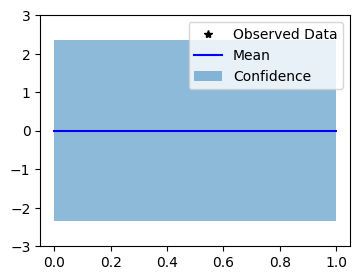

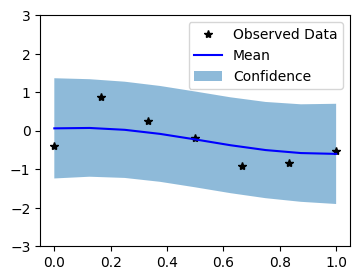

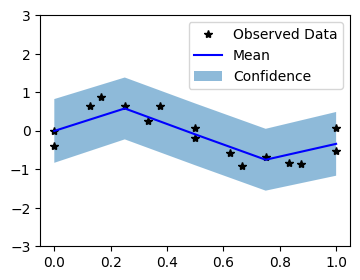

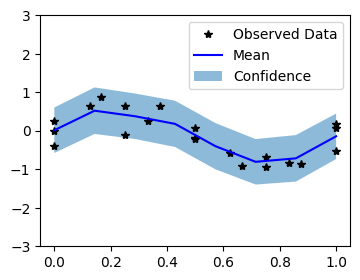

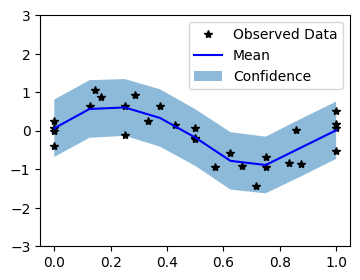

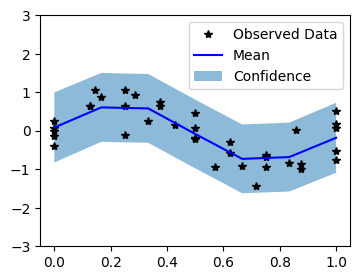

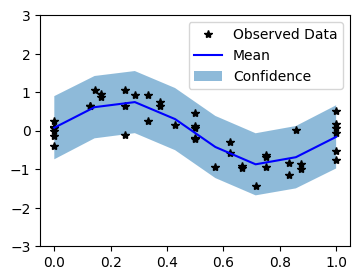

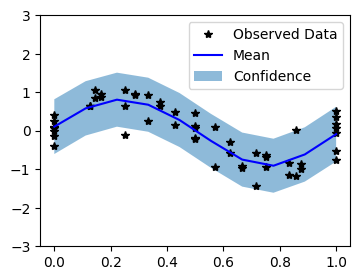

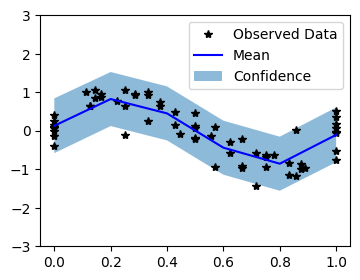

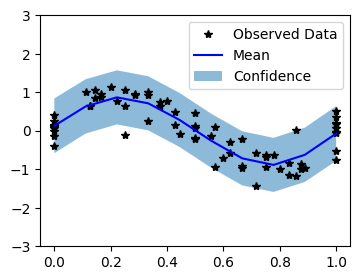

In [14]:
import random

# Initialize empty training data
train_x = torch.empty(0)
train_y = torch.empty(0)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Now, suppose you start receiving new data
for i in range(10):  # Assuming you receive 5 batches of new data
    # Generate new data (for demonstration purposes)
    new_data_x = torch.linspace(0, 1, 5 + random.randint(0, 5))
    new_data_y = torch.sin(new_data_x * (2 * 3.1416)) + torch.randn(new_data_x.size()) * 0.3

    plot(model, likelihood, train_x, train_y, new_data_x)

    # Update model with new data
    if train_x is not None:
        train_x = torch.cat([train_x, new_data_x])
        train_y = torch.cat([train_y, new_data_y])
        
    print(train_y.shape)
        
    # Update model with new data
    # This is not an efficient update.
    model.set_train_data(train_x, train_y.squeeze(), strict=False)

    train_model(train_x, train_y, model, mll, likelihood, optimizer, 10)
        
    

The aforementioned is not efficient. Conditioning each time takes $O((N+N_*)^3)$ time, where $N_*$ is the number of new samples and $N$ is the existing train samples.

What we want is a more efficient approach that updates the that takes advantage of linear algebraic identities. Instead of doing essentially:
```
updated_model = deepcopy(model)
updated_model.set_train_data(torch.cat((train_x, new_x)), torch.cat((train_y, new_y)), strict=False)
```
We can do:
```
updated_model = model.get_fantasy_model(new_x, new_y)
```
which is in $O((N_*)^2N)$ time.